# Collecte des données

In [33]:
import yfinance as yf
import pandas as pd
import numpy as np

tickers = ['AAPL','MSFT', 'GOOG','TSLA']
Data = yf.download(tickers,start="2018-01-02", end="2025-01-02")["Close"]
Data.head()


[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,GOOG,MSFT,TSLA
Date,,,,
2018-01-02,40.304157,52.853584,79.050369,21.368668
2018-01-03,40.297150,53.721081,79.418297,21.150000
2018-01-04,40.484333,53.915627,80.117256,20.974667
2018-01-05,40.945259,54.701229,81.110565,21.105333
2018-01-08,40.793190,54.934975,81.193329,22.427334


Sauvegarde

In [6]:
Data.to_csv("prices.csv")

Calcul des Kpis

In [39]:
prices = pd.read_csv("prices.csv")
prices["Date"] = pd.to_datetime(prices["Date"]) # conversion de la date en datetime

# Rendement journalier
prices = prices.set_index("Date")  # la date devient l'index
daily_returns = prices.pct_change().dropna()  # calcul des rendements jour et on enlève la première ligne vue qu'elle n'a pas de jour -1

# Rendement annuel
annual_returns = prices.mean()*252

# Volatilité  annuelle / risque
annual_Volatility = daily_returns.std()* np.sqrt(252) 

# Rendement par unité de risque
Sharpe_ratio = (annual_returns )/annual_Volatility

print("\n Daily Returns:")
print(daily_returns.head())
print("\n Annual Returns:")
display(annual_returns)
print("\n Annual Volatility:")
display(annual_Volatility)
print("\n Sharpe ratio:")
display(Sharpe_ratio)





 Daily Returns:
                AAPL      GOOG      MSFT      TSLA
Date                                              
2018-01-03 -0.000174  0.016413  0.004654 -0.010233
2018-01-04  0.004645  0.003621  0.008801 -0.008290
2018-01-05  0.011385  0.014571  0.012398  0.006230
2018-01-08 -0.003714  0.004273  0.001020  0.062638
2018-01-09 -0.000115 -0.000614 -0.000680 -0.008085

 Annual Returns:


AAPL    30677.585609
GOOG    25542.777438
MSFT    59469.000087
TSLA    39839.333872
dtype: float64


 Annual Volatility:


AAPL    0.305464
GOOG    0.307423
MSFT    0.288865
TSLA    0.637102
dtype: float64


 Sharpe ratio:


AAPL    100429.521141
GOOG     83086.836978
MSFT    205871.300682
TSLA     62532.120289
dtype: float64

Simulation de 5000 portefeuilles aléatoires

In [45]:
n_portfolios = 5000
weights_list = []
returns_list = []
volatility_list = []
sharpe_list = []
# On génère une liste aléatoire de poids pour les différents actifs du portefeuille 5000 fois pour avoir plusieurs combinanisons pour la fontière efficiente 
for i in range (n_portfolios):
    
    w= np.random.random(len(annual_returns))
    #Normalisation de chaque liste de poids
    w=w/w.sum()
    weights_list.append(w) # on ajoute les poids à la liste de poids
    
    #Caclul du rendement annuel pour chaque combinaison(poids* rendement annuel actif)
    portfolio_returns = np.dot(w, annual_returns)
    returns_list.append(portfolio_returns) # on ajoute les rendements à la liste
    
    # Volatilité annuelle
    portfolio_volatility = np.sqrt(np.dot(w.T, np.dot(daily_returns.cov()*252, w))) # formule de Markov
    volatility_list.append(portfolio_volatility) # on ajout le risque à la liste
    
    # Ratio de Sharpe (sans taux sans risque pour l’instant)
    sharpe = portfolio_returns / portfolio_volatility 
    sharpe_list.append(sharpe)

Construction du DataFrame

In [48]:
portfolios = pd.DataFrame({ 'Return': returns_list, 'Volatility': volatility_list, 'Sharpe': sharpe_list })

# On affiche le poids de chaque actif dans chaque portefeuille

for i, asset in enumerate(annual_returns.index): # on donne un couple (position, actif) à chaque nom d'actif
    portfolios[asset] = [w[i] for w in weights_list] # pour chacun des actifs on récupère le poids dans chaque portefeuille en fonction de sa position i 
portfolios.tail()

,Return,Volatility,Sharpe,AAPL,GOOG,MSFT,TSLA
4995,40231.297932,0.310191,129698.672716,0.120781,0.319925,0.309345,0.249949
4996,40476.728003,0.291950,138642.858050,0.276901,0.222102,0.323468,0.177529
4997,37098.267240,0.294249,126077.646414,0.164441,0.414710,0.239149,0.181700
4998,35633.142173,0.298506,119371.659084,0.102634,0.506445,0.202476,0.188446
4999,49366.015693,0.294034,167892.363607,0.024760,0.180480,0.628323,0.166437


Portefeuille optimal et le portefeuille le moins risqué

In [49]:
# idmax récupère le numéro de ligne contenant le sharpe le plus grand et inversement et loc nous permet de récuperer toute la ligne consernée 

max_sharpe_port = portfolios.loc[portfolios['Sharpe'].idxmax()]
min_vol_port = portfolios.loc[portfolios['Volatility'].idxmin()]


Génération de la frontière efficiente

In [58]:
cov_matrix = daily_returns.cov() * 252

target_returns = np.linspace(portfolios['Return'].min(),
                             portfolios['Return'].max(),
                             100)

efficient_vols = []

for tr in target_returns:
    w = min_vol_for_return(tr, annual_returns.values, cov_matrix)
    vol = portfolio_volatility(w, cov_matrix)
    efficient_vols.append(vol)


In [ ]:
Tracé

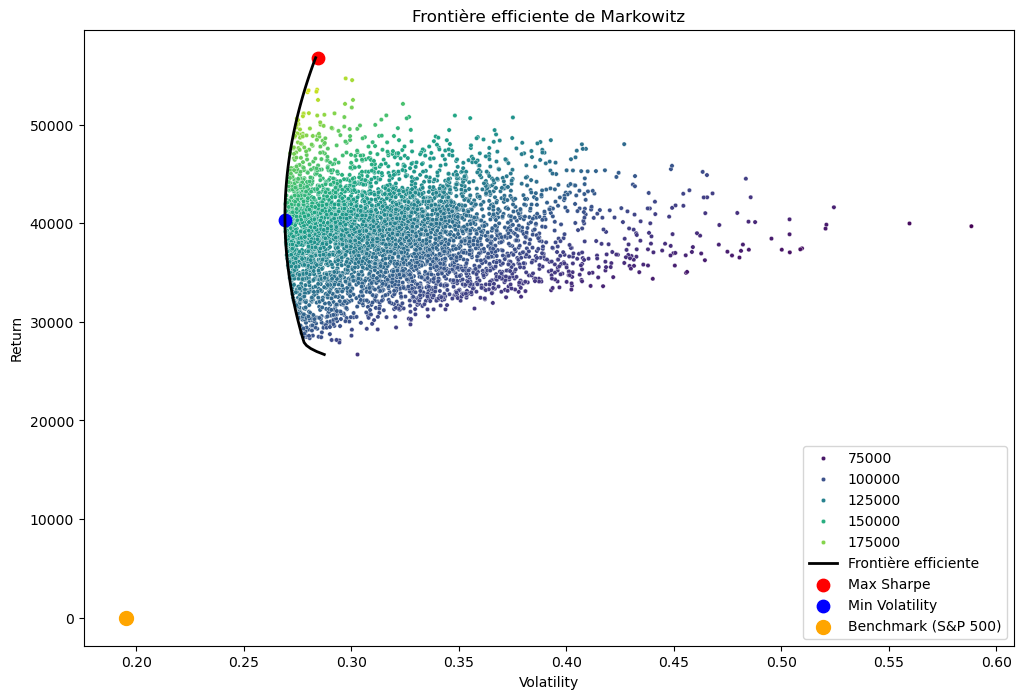

In [64]:
plt.figure(figsize=(12,8))

# Monte Carlo
sns.scatterplot(
    data=portfolios,
    x='Volatility', y='Return',
    hue='Sharpe', palette='viridis', s=10
)

# Frontière efficiente
plt.plot(efficient_vols, target_returns, color='black', linewidth=2, label='Frontière efficiente')

# Portefeuille max Sharpe
plt.scatter(max_sharpe_port['Volatility'], max_sharpe_port['Return'],
            color='red', s=80, label='Max Sharpe')

# Portefeuille min volatilité
plt.scatter(min_vol_port['Volatility'], min_vol_port['Return'],
            color='blue', s=80, label='Min Volatility')
 # importation du Benchmark
plt.scatter(
    benchmark_annual_vol,
    benchmark_annual_return,
    color='orange',
    s=100,
    label='Benchmark (S&P 500)'
)


plt.title("Frontière efficiente de Markowitz")
plt.legend()
plt.show()


In [62]:
import yfinance as yf

benchmark = yf.download("^GSPC", start="2018-01-01")['Close']
benchmark_returns = benchmark.pct_change().dropna()
benchmark_annual_return = benchmark_returns.mean() * 252
benchmark_annual_vol = benchmark_returns.std() * 252**0.5
benchmark_sharpe = benchmark_annual_return / benchmark_annual_vol


[*********************100%***********************]  1 of 1 completed
